# Imports

In [104]:
import pandas as pd
import numpy as np

from math import ceil

from sklearn.model_selection import train_test_split,cross_validate

from imblearn.under_sampling import RandomUnderSampler  
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import time

from sklearn.ensemble import RandomForestClassifier


sns.set()

# Importando a base (resumo)

O foco desse notebook é a aplicação e comparação dos resultados usando um undersampling baseado em clusters, então vamos usar uma base desbalanceada já tratada (Para detalhes do tratamento e da EDA consulotar o notebook 'Projeto_1').

In [137]:
df_covid = pd.read_csv("covid_filled.csv",index_col=0)

# Modelo

Por se tratar de um problema de classificação com features bem definidas de range limitado, escolhhemos o modelo Random Forest para esse estudo, pois não haverá necessidade de extrapolação, devido aos limites das features.

## Objetivo do estudo

Queremos ver os efeitos das diferentes estratégias de balanceamento em um dataset altamente desbalanceado.

Para isso, escolhemos as seguinstes estrátégias:

- SMOTE - Cria dados sintéticos para balancear o dataset

- Random Undersampling (RUS) - Remove dados da classe majoritaria de forma aleatória

- Cluster Based Undersampling (CBU) - Clusteriza a base e remove dados da clase majoritária de cada cluster até deixar o cluster balanceado.

- Stacked CBU - Clusteriza a base e remove dados da clase majoritária de cada cluster até deixar o cluster balanceado. Então é criado um modelo para cada cluster e é feita uma votação por maioria para decidir o output final.

## Dividindo os dados

In [105]:
target = 'covid_res'
features = df_covid.columns.drop([target])

X = df_covid[features]
y = df_covid[target]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y)

## Normalizando as bases

In [106]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std,columns = X.columns)
X_test_std = std.transform(X_test)
X_test_std = pd.DataFrame(X_test_std,columns = X.columns)

## Stacked CBU

A estratégia será implementada  segundo o diagrama abaixo, conforme descrito no paper: 
https://arxiv.org/ftp/arxiv/papers/2005/2005.03582.pdf 

![cbu_diagram.png](imagens/cbu_diagram.png)

Exceto pelas duas diferenças:
- Foi aplicada a mesma testratégia de RUS (Random Under Sampling), independentemente do cluster se altamente desbalanceado ou não.
- Não foi utilizado o cross validation 

Ou seja, nesse código temos:

![new_cbu_diagram.png](imagens/new_cbu_diagram.png)

In [140]:
#Implementação do Stacked CBU

from sklearn.base import clone as clone_model

#realiza o fit dos modelos
def stack_fit(base_est = LogisticRegression(),
              final_est = LogisticRegression(),
              X_train=None,
              y_train=None,
              clusters=None):
    '''
    Realiza o fit dos modelos a serem 'empilhados'
    base_est  -> estimador que será aplicada a cada cluster
    final_est -> modelo que será usado para agregar a saída dos modelos base para realizar a predição final
    X_train   -> base de treino 
    y_train   -> base de teste
    clusters  -> informa em qual cluster cada dado se encontra
    
    De forma resumida, recebe uma base de treino já clusterizada e treina um modelo da instância informada em 'base_est' para cada cluster,
    e tambem treina um modelo da instância informada em 'final_est' para agregar os modelos dos clusters
    
    Retorna os modelos de cada cluster e o modelo agregador
    '''

    #lista com os modelos treinados com cada cluster
    stacked_models =  []
    
    #lista com as predições dos os modelos treinados com cada cluster
    X_train_stack = pd.DataFrame([])

    #para cada cluster, treine um modelo e coloque na lista
    for cluster in np.unique(clusters_us):
        #seleciona 1 cluster
        mask = clusters_us == cluster
        X_train_cl = X_train[mask]
        y_train_cl = y_train[mask]
        
        #treina 1 modelo para cada cluster
        estimator = clone_model(base_est)
        estimator.fit(X_train_cl,y_train_cl)

        stacked_models.append(estimator)
    
    #faça a predição de cada um dos modelos da lista
    #por mais estranho que possa parecer,
    #é necessário fazer uma predição com os dados de treino
    #para poder usar essas predições como base de treino para o estimador final
    for cluster,model in enumerate(stacked_models):
        #cria a base de treino do estimador final
        X_train_stack[cluster] = model.predict(X_train)
    
    #treina o estimador final
    stack_estimator = clone_model(final_est)
    stack_estimator.fit(X_train_stack,y_train)
        
    #retorna a lista com os modelos treinados
    return stacked_models, stack_estimator

#realiza a predição
def stack_predict(stacked_models,
                  stack_estimator,
                  X_test,
                  ts=0.5
                 ):
    '''
    stacked_models -> modelos treinados para cada cluster
    stack_estimator -> modelo treinado para agregar as saídas dos modelos de cada cluster
    X_test -> Base de teste
    ts -> Possível thereshold para ajustar a saída do modelo agregador ('stack_estimator')
    Retorna as predições, bem como suas probabilidades
    '''
    X_test_stack = pd.DataFrame([])

    for cluster,model in enumerate(stacked_models):
        #salva as predições desse modelo
        X_test_stack[cluster] = model.predict(X_test)
    
    y_proba_stack = stack_estimator.predict_proba(X_test_stack)
    y_pred_stack  = (y_proba_stack[:,1] > ts).astype(int)  

    return y_pred_stack, y_proba_stack

In [28]:
def run_model(model, X_train, y_train, X_test, proba=True):
    '''
    Escalona os dados e roda o modelo através de um pipeline.
    Pode retornar ou não as probabilidades de cada predição.
    Retorno: y_pred, y_proba
    dados preditos e probabilidade dos dados
    
    model            -> modelo
    X_train, y_train -> base de treino
    X_test           -> base de teste
    proba, binário: 
                     True  : Retorna as probabilidades. 
                     False : Retorna NONE
    '''
    
    ct = make_column_transformer((StandardScaler(),X_train.columns))  

    pipe = make_pipeline(ct, model)

    pipe.fit(X_train, y_train)
 
    y_pred = pipe.predict(X_test)
    
    if proba:
        try:
            y_proba = pipe.predict_proba(X_test)
        except:
            y_proba = None
    else:
        y_proba = None
    
    return y_pred, y_proba

In [164]:
def test_models_plot_roc_auc_curve(
        model_list,
        X_train,
        X_test,
        y_train,
        y_test,
        stacked_clusters = False,
        clusters = None
):
    """
        model_list       : Lista de modelos a serem testados
                           Formato (List[Dict[model_name|estimator, name|Model]])
        X_train          : Dados de treino (features)
        X_test           : Dados de teste (features)
        y_train          : Dados de treino (alvo)
        y_test           : Dados de teste (alvo)
        stacked_clusters : Usa as funções auxiliares para fit e predict para modelos separados por clusters
    """

    response = {}
    
    for mdl in model_list:

        model = mdl.get('estimator')

        s_fit = time.time()
        
        
        if stacked_clusters:
            #Chama as funções do Stacked CBU
            stacked_models, stack_estimator = stack_fit(model,LogisticRegression(),X_train,y_train,clusters_us)
            s_predict = time.time()
            y_predict, y_predict_proba = stack_predict(stacked_models, stack_estimator,X_test,ts = 0.5)
            e_predict = time.time()

        else:
            #fit predict tradicional
            model.fit(X_train,y_train)
            y_predict_proba = model.predict_proba(X_test)
            s_predict = time.time()
            y_predict  = model.predict(X_test)
            e_predict = time.time()
        
        e_fit = time.time()

        fit_time = round(e_fit-s_fit,3)
        predict_time = round(e_predict-s_predict,3)
        fit_time -= predict_time

        model_name = mdl.get('model_name')
        accuracy = accuracy_score(y_test, y_predict)
        auc = roc_auc_score(y_test, y_predict)
        
        #precision e recall separado por classes
        cm = confusion_matrix(y_test, y_predict)
        precision = cm.diagonal()/cm.sum(axis=0)
        recall = cm.diagonal()/cm.sum(axis=1)
        
        f1 = f1_score(y_test, y_predict, average='weighted')

        response[mdl.get('model_name')]  = {
            "accuracy": accuracy,
            "precision[0]": precision[0],
            "recall[0]": recall[0],
            "precision[1]": precision[1],
            "recall[1]": recall[1],
            "f1_score": f1,
            "auc": auc,
            "fit_time":fit_time,
            "pred_time":predict_time
        }
    return response

column_order = ['accuracy', 'auc', 'f1_score', 'precision[0]', 'recall[0]','precision[1]', 'recall[1]', 'fit_time', 'pred_time']

In [161]:
random_seed = 42

list_models = [
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed,n_jobs=-1)}
]

Verificanco o quão desbalanceada a base está em relação aos targets

In [162]:
print('Percentual')
display(y_train.value_counts(normalize=True))
print('Valores absolutos')
display(y_train.value_counts())

Percentual


0    0.558519
1    0.441481
Name: covid_res, dtype: float64

Valores absolutos


0    193958
1    153314
Name: covid_res, dtype: int64

In [165]:
response_bank = test_models_plot_roc_auc_curve(list_models,
                                               X_train_std,
                                               X_test_std,
                                               y_train,
                                               y_test)

candidates = (pd.DataFrame(response_bank).T[column_order])
candidates

,accuracy,auc,f1_score,precision[0],recall[0],precision[1],recall[1],fit_time,pred_time
Random Forest,0.624987,0.59567,0.5978,0.620456,0.846171,0.639468,0.345169,4.338,0.213


## Balanceando os dados

### SMOTE

In [37]:
smote = SMOTE(random_state=42,sampling_strategy='auto',n_jobs=-1)
X_train_sm, y_train_sm = smote.fit_resample(X_train_std, y_train)
X_train_sm = pd.DataFrame(X_train_sm,columns = X.columns)

In [38]:
y_train.value_counts()

0    193958
1    153314
Name: covid_res, dtype: int64

In [39]:
y_train_sm.value_counts()

1    193958
0    193958
Name: covid_res, dtype: int64

In [166]:
response_bank_sm = test_models_plot_roc_auc_curve(list_models,
                                                  X_train_std,
                                                  X_test_std,
                                                  y_train,
                                                  y_test)

candidates_sm = (pd.DataFrame(response_bank_sm).T[column_order])
candidates_sm

,accuracy,auc,f1_score,precision[0],recall[0],precision[1],recall[1],fit_time,pred_time
Random Forest,0.624987,0.59567,0.5978,0.620456,0.846171,0.639468,0.345169,4.385,0.213


### CBU (Clustering Based Undersampling)

In [117]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.base import clone
from sklearn.utils import check_random_state
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier

#### Dividindo a base em clusters:

##### Calculando o número de clusters

In [118]:
def calculate_wcss(data):
    wcss = []

    for n in range(2, 20):
        model = KMeans(n_clusters=n, random_state=42)
        model.fit(X=data)
        wcss.append(model.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


In [45]:
n_clusters = optimal_number_of_clusters(calculate_wcss(X_train_std))

n_clusters

12

#### Criando os clusters

In [51]:
km = KMeans(n_clusters= n_clusters,random_state=42)
km.fit(X_train_std)
km_clusters = km.predict(X_train_std)
km_clusters

array([0, 4, 0, ..., 0, 0, 1])

#### Perfil dos clusters

##### Distribuição de resultados positivos e negativos em cada cluster

In [119]:
for cluster in np.unique(km_clusters):    
    print('Cluster:',cluster)
    mask = km_clusters== cluster
    print(y_train[mask].value_counts())

Cluster: 0
0    64626
1    48263
Name: covid_res, dtype: int64
Cluster: 1
1    28695
0    11622
Name: covid_res, dtype: int64
Cluster: 2
1    4490
0    1751
Name: covid_res, dtype: int64
Cluster: 3
0    2780
1    2620
Name: covid_res, dtype: int64
Cluster: 4
0    77419
1    45638
Name: covid_res, dtype: int64
Cluster: 5
0    1551
1    1017
Name: covid_res, dtype: int64
Cluster: 6
0    14554
1     9111
Name: covid_res, dtype: int64
Cluster: 7
0    6116
1    3538
Name: covid_res, dtype: int64
Cluster: 8
0    2720
1    2374
Name: covid_res, dtype: int64
Cluster: 9
0    3088
1    1801
Name: covid_res, dtype: int64
Cluster: 10
0    4638
1    3202
Name: covid_res, dtype: int64
Cluster: 11
0    3093
1    2565
Name: covid_res, dtype: int64


##### Visualização dos clusters

In [120]:
pca = PCA(4)
components = pca.fit_transform(X_train_std)

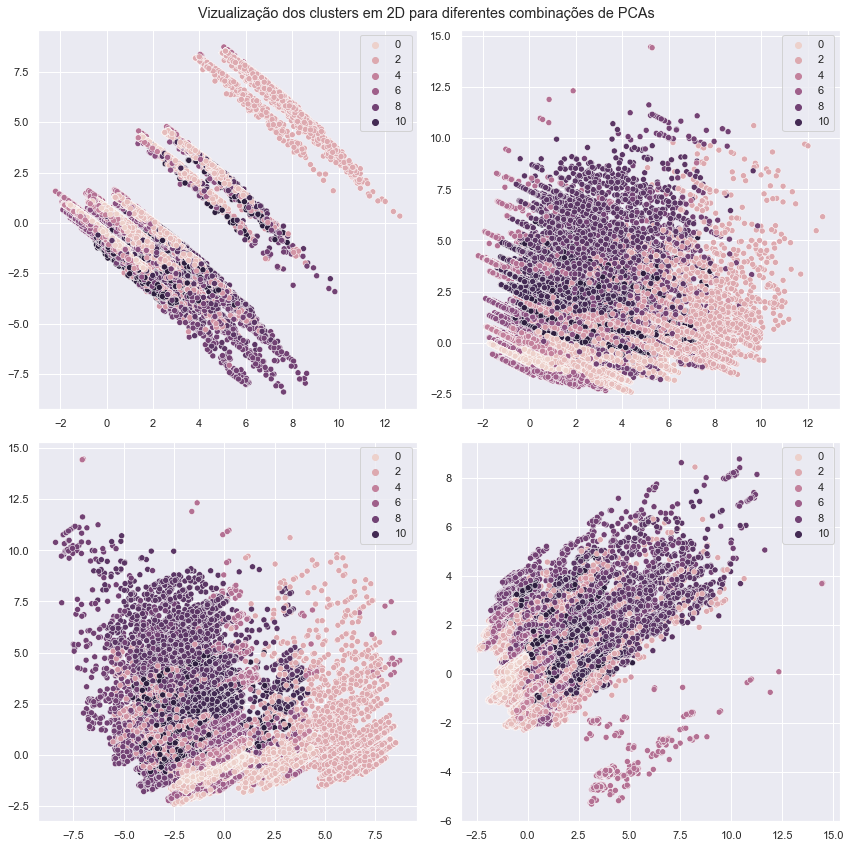

In [56]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.scatterplot(x=components[:,0],y=components[:,1],hue=km_clusters,ax=ax[0][0])
sns.scatterplot(x=components[:,0],y=components[:,2],hue=km_clusters,ax=ax[0][1])
sns.scatterplot(x=components[:,1],y=components[:,2],hue=km_clusters,ax=ax[1][0])
sns.scatterplot(x=components[:,2],y=components[:,3],hue=km_clusters,ax=ax[1][1])

fig.suptitle('Vizualização dos clusters em 2D para diferentes combinações de PCAs')

fig.tight_layout()

#### Visualização em 3d utilizando as 3 principais componentes do PCA

In [48]:
#import plotly
#import plotly.graph_objs as go
#
## Configure Plotly to be rendered inline in the notebook.
#plotly.offline.init_notebook_mode()
#
## Configure the trace.
#trace = go.Scatter3d(
#    x=components[:,0],  # <-- Put your data instead
#    y=components[:,1],  # <-- Put your data instead
#    z=components[:,2],  # <-- Put your data instead
#    mode='markers',
#    marker={
#        'size': 5,
#        'opacity': 0.8,
#        'color':km_clusters,
#        'colorscale':'deep'
#    }
#)
#
## Configure the layout.
#layout = go.Layout(
#    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
#)
#
#data = [trace]
#
#plot_figure = go.Figure(data=data, layout=layout)
#
## Render the plot.
#plotly.offline.iplot(plot_figure)

#### Fazendo o undersampling em cada cluster

In [57]:
rus = RandomUnderSampler(random_state=1)

X_train_us=np.array([])
clusters_us = []

#para cada cluster
for cluster in np.unique(km_clusters):

    #faça o undersamping dentro da cada cluster
    mask = km_clusters == cluster
    X_train_temp, y_train_temp = rus.fit_resample(X_train_std[mask],y_train[mask])
    cluster_temp = np.ones_like(y_train_temp)*cluster

    #concatene os clusters para formar a base de treino
    if (cluster == 0):
        X_train_us  = X_train_temp
        y_train_us  = y_train_temp
        clusters_us = cluster_temp
    else:  
        X_train_us  = np.concatenate([X_train_us , X_train_temp])
        y_train_us  = np.concatenate([y_train_us , y_train_temp])
        clusters_us = np.concatenate([clusters_us, cluster_temp])

In [58]:
X_train_us = pd.DataFrame(X_train_us,columns = X.columns)
y_train_us = pd.Series(y_train_us)
X_train_us.head()

,sex,age,pregnancy,pneumonia,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,other_disease,home_treatment,icu,intubed
0,-0.985426,0.976099,-0.086313,-0.42962,2.657272,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
1,-0.985426,-0.012050,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
2,-0.985426,-0.444366,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
3,-0.985426,-0.876681,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522
4,-0.985426,-0.259088,-0.086313,-0.42962,-0.376326,-0.125301,-0.182841,-0.127465,-0.43684,-0.150344,-0.442911,-0.142274,-0.306382,-0.178094,0.519774,-0.166769,-0.135522


Comparando o resultado de balanceamento de cada método

In [59]:
print('Originalmente')
y_train.value_counts()

Originalmente


0    193958
1    153314
Name: covid_res, dtype: int64

In [60]:
print('Após SMOTE')
y_train_sm.value_counts()

Após SMOTE


1    193958
0    193958
Name: covid_res, dtype: int64

In [61]:
print('Após CBU')
y_train_us.value_counts()

Após CBU


0    133502
1    133502
dtype: int64

#### Calculando o desempenho do modelo

In [167]:
response_bank_us = test_models_plot_roc_auc_curve(list_models,
                                                  X_train_us,
                                                  X_test_std,
                                                  y_train_us,
                                                  y_test)

candidates_cbu = (pd.DataFrame(response_bank_us).T[column_order])
candidates_cbu

,accuracy,auc,f1_score,precision[0],recall[0],precision[1],recall[1],fit_time,pred_time
Random Forest,0.584854,0.570201,0.578657,0.61317,0.695411,0.535925,0.444991,2.442,0.212


### Treinando um modelo com cada cluster e depois fazendo o stack

Agora existe um modelo para cada cluster. Esses modelos são usados para predizer os resultados e depois, usamos um outro estimador para ponderar esses resultados e obter a predição final.

Diferenças:
- Por praticidade eu balanceei todos os clusters (os altamente desbalanceados e os pouco desbalanceados)
- O cross validation não foi implementado nesse momento

In [171]:
response_bank_stack = test_models_plot_roc_auc_curve(list_models,
                                                     X_train_us,
                                                     X_test_std,
                                                     y_train_us,
                                                     y_test,
                                                     stacked_clusters=True,
                                                     clusters = clusters_us
                                                    )

candidates_stack = (pd.DataFrame(response_bank_stack).T[column_order])
candidates_stack

,accuracy,auc,f1_score,precision[0],recall[0],precision[1],recall[1],fit_time,pred_time
Random Forest,0.60614,0.600569,0.6061,0.64718,0.648168,0.554041,0.55297,5.445,1.823


## Comparando o resultado das estratégias de balanceamento

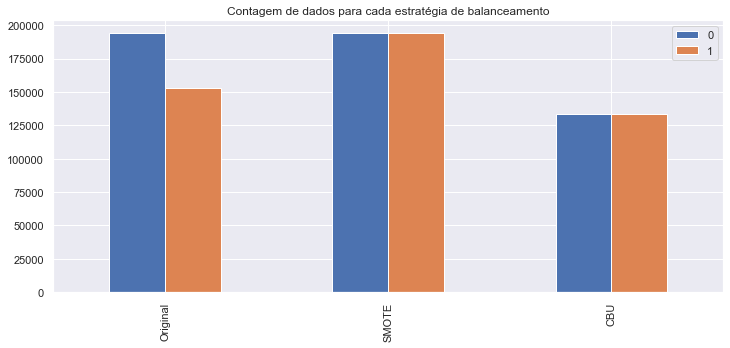

In [189]:
data_count = pd.concat([y_train.value_counts(),y_train_sm.value_counts(),y_train_us.value_counts()],axis=1)
data_count.columns = ['Original', 'SMOTE', 'CBU']

data_count.T.plot(kind = 'bar',
                figsize = (12,5),
                title = 'Contagem de dados para cada estratégia de balanceamento'
               );

In [172]:
rf_results = pd.concat([candidates,
                        candidates_sm,
                        candidates_cbu,
                        candidates_stack
                       ],axis=0)

rf_results.index = ['Sem balanceamento','SMOTE','CBU','Stacked CBU']

In [173]:
print('\n\nModelo: Random Forest')
display(rf_results)



Modelo: Random Forest


,accuracy,auc,f1_score,precision[0],recall[0],precision[1],recall[1],fit_time,pred_time
Sem balanceamento,0.624987,0.595670,0.597800,0.620456,0.846171,0.639468,0.345169,4.338,0.213
SMOTE,0.624987,0.595670,0.597800,0.620456,0.846171,0.639468,0.345169,4.385,0.213
CBU,0.584854,0.570201,0.578657,0.613170,0.695411,0.535925,0.444991,2.442,0.212
Stacked CBU,0.606140,0.600569,0.606100,0.647180,0.648168,0.554041,0.552970,5.445,1.823


O objetivo principal de se balancear uma base de dados é aumentar o recall das classes minoritárias (que o modelo aprenda corretamente a nuance das classes minoritárias e a identifique). Tendo isso em mente, é possível observar que a estratégia de Stacked CBU prosposta no paper teve o melhor resultado.

O Custo disso foi um maior gasto computacional no treinamento dos modelos e na predição.

Outras métricas tiveram poucas alterações. É possível observar que , embora a acurácia global tenha diminuído um pouco para o Stacked CBU, os valores de AUC e F1_score aumentaram.